In [1]:
#All the required imports
import requests
import json
from pymongo import MongoClient
import pandas as pd
import datetime as dt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import psycopg2
import csv
import numpy as np
import datetime as dt
import plotly.express as px
import pandas as pd
import altair as alt
from random import sample

In [10]:
complaints_data = pd.read_csv("complaint.csv") 
arrest_data = pd.read_csv("arrest_data.csv") 
summons_data =  pd.read_csv("courtsummon.csv")
prison_data = pd.read_csv("PrisonAdmissions.csv")
complaints_data['cmplnt_fr_dt'] = pd.to_datetime(complaints_data.cmplnt_fr_dt)
summons_data['summons_date'] = pd.to_datetime(summons_data.summons_date)
arrest_data['arrest_date'] = pd.to_datetime(arrest_data.arrest_date)

In [11]:
## Concatinating data from all the dataframes by month
arrest_by_month = arrest_data.arrest_date.dt.month.value_counts().sort_index()
complaints_by_month = complaints_data.cmplnt_fr_dt.dt.month.value_counts().sort_index()
summons_by_month = summons_data.summons_date.dt.month.value_counts().sort_index()
prison_by_month = prison_data.MonthCode.value_counts().sort_index()

month_data = pd.concat([arrest_by_month,complaints_by_month,summons_by_month,prison_by_month],axis=1)
month_data.rename({'arrest_date': 'Arrests', 'cmplnt_fr_dt': 'Complaints','summons_date':'Summons','MonthCode':'Prison'}, axis=1, inplace=True)
#month_data.plot(kind='line')

arrest_by_month.rename(index = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',
                          11:'Nov',12:'Dec'},inplace = True)
complaints_by_month.rename(index = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',
                          11:'Nov',12:'Dec'},inplace = True)
summons_by_month.rename(index = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',
                          11:'Nov',12:'Dec'},inplace = True)
prison_by_month.rename(index = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',
                          11:'Nov',12:'Dec'},inplace = True)

In [12]:
## Scraping NYC Bourough population of 2018

import requests
import lxml.html as lh

url = 'https://www.citypopulation.de/en/usa/newyorkcity/'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))
    
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 10, the //tr data is not from our table 
    if len(T)!=7:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1
      
Dict={title:column for (title,column) in col}
pop = pd.DataFrame(Dict)

pop = pop[pop.columns[[0,5]]]

pop.replace({'Brooklyn (Kings County)':'BROOKLYN','Bronx':'BRONX',
            'Queens':'QUEENS','Manhattan (New York County)':'MANHATTAN',
             'Staten Island (Richmond County)':'STATEN ISLAND'}, inplace=True)

pop.rename({'PopulationEstimate2018-07-01':'Pop2018'},axis=1,inplace = True)

pop = pop.iloc[0:5]
pop.set_index(['Name'],inplace = True)

for i in range(len(pop['Pop2018'])):
    pop.iloc[i,0]= int(str(pop.iloc[i,0]).replace(',',''))

<function matplotlib.pyplot.show(*args, **kw)>

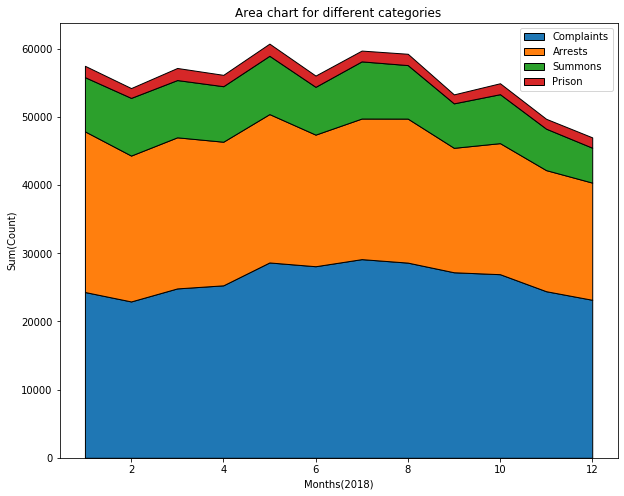

In [13]:
## Plotting data by month as a stacked line chart
x = month_data.index
y = np.vstack([complaints_by_month,arrest_by_month,summons_by_month,prison_by_month])

plt.figure(figsize=(10,8))
labels = ['Complaints','Arrests','Summons','Prison']
plt.stackplot(x,y,
             labels = labels,
             edgecolor = 'black')
plt.xlabel('Months(2018)')
plt.ylabel('Sum(Count)')
plt.title('Area chart for different categories')
plt.legend(loc=1)
plt.show

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

`Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='line')` instead of `Series.plot('line',)`.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

`Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='line')` instead of `Series.plot('line',)`.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

`Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='line')` instead of `Series.plot('line',)`.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

`Series.plot()` 

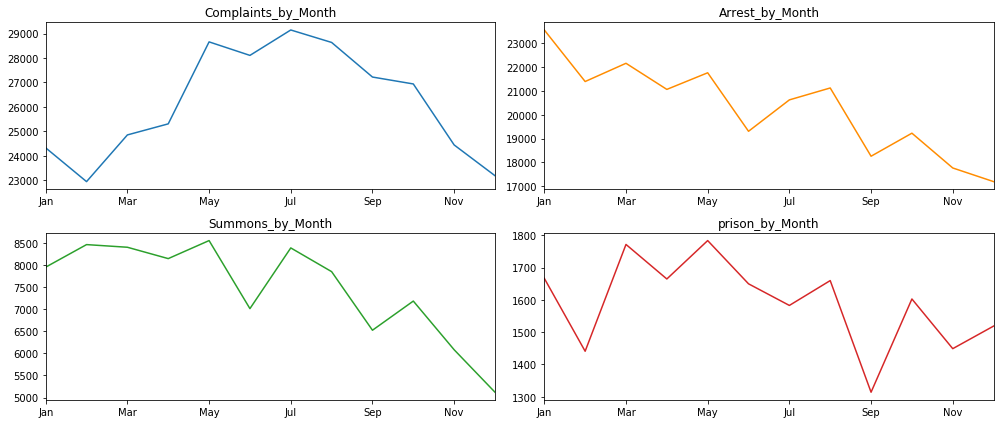

In [14]:
fig, ax = plt.subplots(2, 2,figsize = (14,6))
complaints_by_month.plot("line", ax=ax[0,0]).set_title('Complaints_by_Month')
arrest_by_month.plot("line", ax=ax[0,1],color='#ff8c00').set_title('Arrest_by_Month')
summons_by_month.plot("line", ax=ax[1,0],color = '#2ca02c').set_title('Summons_by_Month')
prison_by_month.plot("line", ax=ax[1,1],color = '#d62728').set_title('prison_by_Month')
plt.tight_layout()
plt.show()

,Complaints,Arrests,Summons,Prison
BRONX,0.049144,0.038283,0.016075,0.000811
BROOKLYN,0.036706,0.026182,0.008850,0.000499
MANHATTAN,0.041367,0.037696,0.015533,0.001606
QUEENS,0.029127,0.021637,0.006435,0.000518
STATEN ISLAND,0.031093,0.021673,0.008022,0.000477


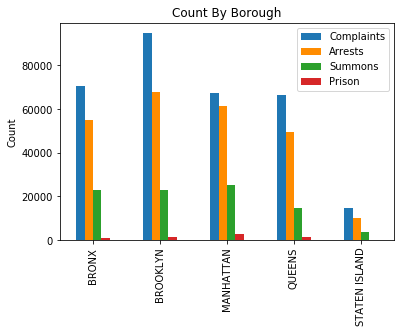

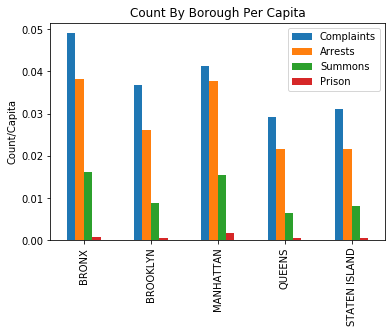

In [15]:
### Plotting data by Boruoughs
arrest_boro = arrest_data.arrest_boro.value_counts()
arrest_boro.rename(index = {'K':'BROOKLYN','B':'BRONX','Q':'QUEENS','M':'MANHATTAN','S':'STATEN ISLAND'}, inplace=True)
comp_boro = complaints_data.boro_nm.value_counts()
summon_boro = summons_data.boro.value_counts()
summon_boro.rename(index = {'NEW YORK':'MANHATTAN'},inplace=True)
prison_boro = prison_data.Borough.value_counts()

#boro = pd.merge(arrest_boro, comp_boro, left_index=True, right_index=True)
boro = pd.concat([comp_boro,arrest_boro,summon_boro,prison_boro], axis=1, sort=True)
boro.rename({'arrest_boro': 'Arrests', 'boro_nm': 'Complaints','boro':'Summons','Borough':'Prison'}, axis=1, inplace=True)
boro.plot.bar(color = ('#1f77b4','#ff8c00','#2ca02c','#d62728')).set_title('Count By Borough')
plt.ylabel('Count')

boro.div(pop['Pop2018'],axis=0).plot.bar().set_title('Count By Borough Per Capita')
plt.ylabel('Count/Capita')

boro.div(pop['Pop2018'],axis=0)

In [16]:
arrest_data.head(10)

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,latitude,longitude
0,173134150,2018-01-01,115,RECKLESS ENDANGERMENT 2,355,OFFENSES AGAINST THE PERSON,PL 1202000,M,MANHATTAN,10,0,25-44,M,WHITE HISPANIC,40.741689,-74.002986
1,173130596,2018-01-01,969,"TRAFFIC,UNCLASSIFIED INFRACTION",881,OTHER TRAFFIC INFRACTION,VTL051101A,M,MANHATTAN,7,0,18-24,M,WHITE,40.711631,-73.985800
2,173134155,2018-01-01,113,"MENACING,UNCLASSIFIED",344,ASSAULT 3 & RELATED OFFENSES,PL 1201500,M,MANHATTAN,28,0,45-64,M,BLACK,40.806031,-73.956099
3,173134301,2018-01-01,101,ASSAULT 3,344,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,BRONX,49,0,25-44,M,BLACK,40.868309,-73.864374
4,173135229,2018-01-01,503,"CONTROLLED SUBSTANCE,INTENT TO SELL 3",117,DANGEROUS DRUGS,PL 2201602,F,BRONX,52,0,25-44,M,WHITE HISPANIC,40.868557,-73.888316
5,173135243,2018-01-01,782,"WEAPONS, POSSESSION, ETC",236,DANGEROUS WEAPONS,PL 2650101,M,MANHATTAN,6,0,25-44,M,WHITE HISPANIC,40.733521,-74.003534
6,173135541,2018-01-01,905,"INTOXICATED DRIVING,ALCOHOL",347,INTOXICATED & IMPAIRED DRIVING,VTL11920U3,M,MANHATTAN,33,0,25-44,M,WHITE HISPANIC,40.840781,-73.936245
7,173142144,2018-01-01,904,"INTOXICATED DRIVING,ALCOHOL",119,INTOXICATED/IMPAIRED DRIVING,VTL11920E3,F,BRONX,47,0,45-64,M,BLACK,40.894671,-73.861361
8,173142150,2018-01-01,109,"ASSAULT 2,1,UNCLASSIFIED",106,FELONY ASSAULT,PL 1200502,F,BRONX,46,0,25-44,M,BLACK HISPANIC,40.853587,-73.900591
9,173142171,2018-01-01,269,"MISCHIEF,CRIMINAL, UNCL 2ND DEG 3RD DEG",121,CRIMINAL MISCHIEF & RELATED OFFENSES,PL 1450500,F,BROOKLYN,83,0,25-44,M,WHITE HISPANIC,40.705323,-73.919398


In [17]:
summons_data.head(10)

,summons_key,summons_date,offense_description,law_section_number,age_group,sex,race,jurisdiction_code,boro,precinct_of_occur,latitude,longitude
0,174350856,2018-01-01,OTHER ACA,9999,18-24,M,ASIAN / PACIFIC ISLANDER,0,QUEENS,114,40.761608,-73.924589
1,173303103,2018-01-01,TRESPASS,140.05,18-24,M,WHITE,0,NEW YORK,19,40.786244,-73.953902
2,173249490,2018-01-01,UNLICENSED VEHICLE FOR HIRE,19-506,45-64,M,BLACK,0,BROOKLYN,70,40.649448,-73.963078
3,173205994,2018-01-01,"MARIJUANA, POSSESSION OF",221.05,18-24,F,BLACK,0,QUEENS,105,40.752253,-73.702112
4,173205905,2018-01-01,OTHER VTL,9999,25-44,M,BLACK HISPANIC,0,NEW YORK,34,40.853208,-73.934195
5,173205915,2018-01-01,EXPOSURE OF PERSON,245.01,18-24,F,BLACK HISPANIC,0,BRONX,47,40.887089,-73.867786
6,173205937,2018-01-01,DISORDERLY CONDUCT,240.2,18-24,F,BLACK,2,QUEENS,114,40.760782,-73.934145
7,173303147,2018-01-01,OTHER VTL,9999,45-64,M,BLACK HISPANIC,0,BRONX,44,40.823794,-73.926159
8,173205962,2018-01-01,KEY IN IGNITION,10-111,25-44,M,AMERICAN INDIAN/ALASKAN NATIVE,0,BROOKLYN,77,40.675204,-73.941653
9,173249492,2018-01-01,ACCEPT ON HAIL,19-507,45-64,M,BLACK,0,BROOKLYN,70,40.649448,-73.963078


In [18]:
complaints_data.head()

,cmplnt_num,cmplnt_fr_dt,cmplnt_fr_tm,addr_pct_cd,rpt_dt,ky_cd,ofns_desc,pd_cd,pd_desc,crm_atpt_cptd_cd,...,susp_sex,latitude,longitude,patrol_boro,vic_age_group,vic_race,vic_sex,day,month,month_number
0,774621657,2018-10-08,12:30:00,43,2018-10-08T00:00:00.000,105,ROBBERY,397,"ROBBERY,OPEN AREA UNCLASSIFIED",COMPLETED,...,M,40.823836,-73.861624,PATROL BORO BRONX,<18,BLACK,M,Monday,October,10
1,232548146,2018-08-24,11:00:00,78,2018-08-25T00:00:00.000,341,PETIT LARCENY,338,"LARCENY,PETIT FROM BUILDING,UN",COMPLETED,...,M,40.667412,-73.986123,PATROL BORO BKLYN SOUTH,45-64,WHITE,F,Friday,August,8
2,620357753,2018-10-02,16:00:00,105,2018-10-03T00:00:00.000,341,PETIT LARCENY,349,"LARCENY,PETIT OF LICENSE PLATE",COMPLETED,...,F,40.661923,-73.748389,PATROL BORO QUEENS SOUTH,65+,BLACK,M,Tuesday,October,10
3,340031034,2018-06-07,23:30:00,73,2018-06-08T00:00:00.000,344,ASSAULT 3 & RELATED OFFENSES,101,ASSAULT 3,COMPLETED,...,F,40.663056,-73.910971,PATROL BORO BKLYN NORTH,18-24,BLACK,F,Thursday,June,6
4,640327678,2018-06-20,16:40:00,101,2018-06-20T00:00:00.000,578,HARRASSMENT 2,638,"HARASSMENT,SUBD 3,4,5",COMPLETED,...,F,40.602281,-73.753357,PATROL BORO QUEENS SOUTH,45-64,BLACK,F,Wednesday,June,6


In [19]:
prison_data.head()

,Unnamed: 0,AdmissionYear,AdmissionMonth,MonthCode,AdmissionType,CountyOfCommitment,LastKnownResidenceCounty,Gender,AgeOfAdmission,MostSeriousCrime,AgeRange,Borough
0,0,2018,JANUARY,1,NEW COURT COMMITMENT,BRONX,MISSING,MALE,40,CPCS 3RD,25-44,BRONX
1,1,2018,JANUARY,1,NEW COURT COMMITMENT,ALBANY,MISSING,MALE,17,ASSAULT 2ND,< 18,NaN
2,2,2018,JANUARY,1,NEW COURT COMMITMENT,ALBANY,MISSING,MALE,17,ASSAULT 2ND,< 18,NaN
3,3,2018,JANUARY,1,NEW COURT COMMITMENT,ALBANY,MISSING,MALE,20,CPCS 5TH,18-24,NaN
4,4,2018,JANUARY,1,NEW COURT COMMITMENT,ALBANY,MISSING,MALE,21,CPCS 3RD,18-24,NaN


In [20]:
prison_data= prison_data.dropna()
prison_data.Borough.unique()

array(['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'],
      dtype=object)

In [22]:
## Multi stacked bar plot
arrest_age_boro = pd.crosstab(arrest_data.arrest_boro,arrest_data.age_group)
arrest_age_boro.rename(index = {'K':'BROOKLYN','B':'BRONX',
                            'Q':'QUEENS','M':'MANHATTAN','S':'STATEN ISLAND'}, inplace=True)
comp_age_boro = pd.crosstab(complaints_data.boro_nm,complaints_data.susp_age_group)
summon_age_boro = pd.crosstab(summons_data.boro,summons_data.age_group)
summon_age_boro.rename(index = {'NEW YORK':'MANHATTAN'},inplace=True)
prison_age_boro = pd.crosstab(prison_data.Borough,prison_data.AgeRange)
prison_age_boro.rename(columns = {'< 18':'<18'}, inplace=True)

def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns = ['c1', 'c2', 'values']
    df['DF'] = name
    return df

df1 = prep_df(arrest_age_boro, 'Arrest')
df2 = prep_df(comp_age_boro, 'Complaints')
df3 = prep_df(summon_age_boro, 'Court Summons')
df4 = prep_df(prison_age_boro, 'Prison')

df = pd.concat([df1, df2, df3, df4])


alt.Chart(df).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('c2:N', title=None),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(values):Q',
        axis=alt.Axis(
            grid=False)),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('c1:N', title=None,header= alt.Header(title = 'Crimes by Age Group and Borough')),
    
    order=alt.Order(
      # Sort the segments of the bars by this field
      'values',
      sort='descending'),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('DF:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#ff8c00','#1f77b4', '#2ca02c','#d62728']
            ),
        ))\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    )

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [23]:
## Multi stacked bar plot
arrest_sex_boro = pd.crosstab(arrest_data.arrest_boro,arrest_data.perp_sex)
arrest_sex_boro.rename(index = {'K':'BROOKLYN','B':'BRONX',
                            'Q':'QUEENS','M':'MANHATTAN','S':'STATEN ISLAND'}, inplace=True)
comp_sex_boro = pd.crosstab(complaints_data.boro_nm,complaints_data.susp_sex)
summon_sex_boro = pd.crosstab(summons_data.boro,summons_data.sex)
summon_sex_boro.rename(index = {'NEW YORK':'MANHATTAN'},inplace=True)
prison_sex_boro = pd.crosstab(prison_data.Borough,prison_data.Gender)
prison_sex_boro.rename(columns = {'FEMALE':'F', 'MALE':'M'}, inplace=True)


def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns = ['c1', 'c2', 'values']
    df['DF'] = name
    return df

df1 = prep_df(arrest_sex_boro, 'Arrest')
df2 = prep_df(comp_sex_boro, 'Complaints')
df3 = prep_df(summon_sex_boro, 'Court Summons')
df4 = prep_df(prison_sex_boro, 'Prison')

df = pd.concat([df1, df2, df3, df4])

alt.Chart(df).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('c2:N', title=None),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(values):Q',
        axis=alt.Axis(
            grid=False
            )),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('c1:N', title=None,header= alt.Header(title = 'Crimes by Gender and Borough')),
    
    order=alt.Order(
      # Sort the segments of the bars by this field
      'values',
      sort='descending'
    ),

    # tell Altair which field to use for color segmentation 
    color = alt.Color('DF:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
               range=['#ff8c00','#1f77b4', '#2ca02c','#d62728'])
            ),
        )\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    )

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


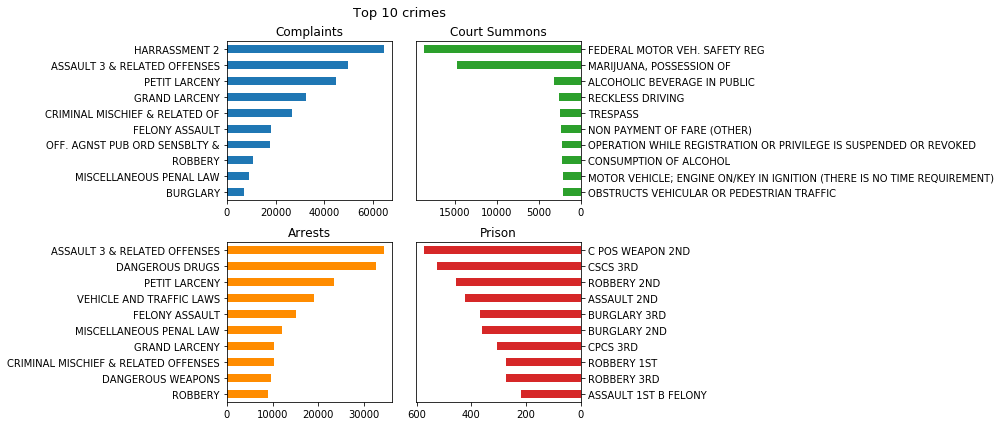

In [24]:
fig, ax = plt.subplots(2, 2,figsize = (14,6))
#arrest_by_month.plot("line", ax=ax[0,0]).set_title('Arrest_by_Month')
complaints_data.ofns_desc.value_counts()[:10].plot.barh(ax=ax[0,0],).set_title('Complaints')
ax[0,0].invert_yaxis()
arrest_data.ofns_desc.value_counts()[:10].plot.barh(ax=ax[1,0],color='#ff8c00').set_title('Arrests')
ax[1,0].invert_yaxis()
summons_data.offense_description.value_counts()[:10].plot.barh(ax=ax[0,1],color = '#2ca02c').set_title('Court Summons')
ax[0,1].invert_yaxis()
ax[0,1].yaxis.tick_right()
ax[0,1].invert_xaxis()
prison_data.MostSeriousCrime.value_counts()[:10].plot.barh(ax=ax[1,1],color= '#d62728').set_title('Prison')
ax[1,1].invert_yaxis()
ax[1,1].yaxis.tick_right()
ax[1,1].invert_xaxis()
plt.tight_layout()
fig.suptitle('Top 10 crimes',size = 13, x=0.4)
fig.subplots_adjust(top=0.90)
plt.show()

In [26]:
from folium.plugins import HeatMap
import folium
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=12):
    tiles = 'Stamen Terrain'
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start,tiles = tiles)
    return base_map

arrest_data['count'] = 1
base_map = generateBaseMap()
lat_long = arrest_data[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude', 'count']).sum().reset_index().values.tolist()
HeatMap(data=sample(lat_long,30000),
        radius=8, max_zoom=13).add_to(base_map)

base_map